======================================================
### **Student Information:**
* Name = Peyman
* Last Name = Naseri
* ID = 96100522

======================================================

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use("ggplot")

#for ignore warning 
import datetime
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import warnings                                            
warnings.filterwarnings('ignore')

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior

<function tensorflow.python.compat.v2_compat.disable_v2_behavior()>

# DATA

## load orginal data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


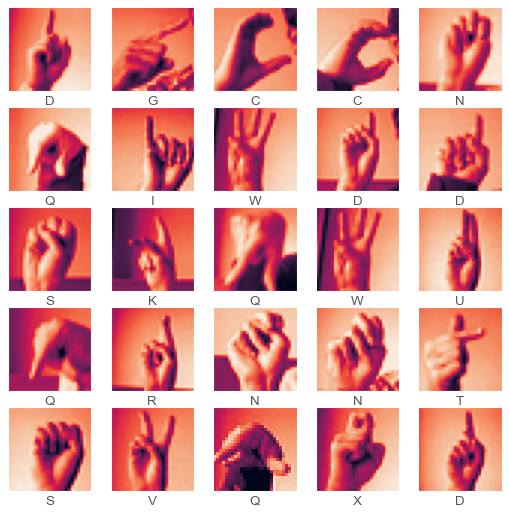

In [2]:
df_train = pd.read_csv('Q1_train.csv')
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)
y = df_train['label'].to_numpy()
X = df_train.drop(columns=['label']).to_numpy()
for i in range(0,25): 
    plt.subplot(5,5,i+1) #create subplots
    mat_data = X[i].reshape(28,28)  #reshape images
    plt.imshow(mat_data) #plot the data
    plt.xlabel(chr(y[i]+65))
    plt.xticks([]) #removes numbered labels on x-axis
    plt.yticks([]) #removes numbered labels on y-axis
df_train.head()

## load test data

In [3]:
df_test = pd.read_csv('Q1_test.csv')
y_test = df_train['label'].to_numpy().astype(float)
X_test = df_train.drop(columns=['label']).to_numpy().astype(float)


## load my test data

In [4]:
#get image from camera for test on network
import cv2 #opencv library for image processing
from matplotlib.pyplot import figure
# define a video capture object
def read_resize_image():
    vid = cv2.VideoCapture(0)
    while(True):
        # Capture the video frame
        # by frame
        ret, frame = vid.read()
        # Display the resulting frame
        cv2.imshow('frame', frame)
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break        
    vid.release() # After the loop release the cap object
    cv2.destroyAllWindows() # Destroy all the windows
    resized_image = cv2.resize(frame[:,:,0], (28, 28)) #resize 28*28
    return(resized_image.reshape(-1))

In [5]:
# for online test
num_imges = 5
import os.path
if os.path.exists('my_test.csv'):
    df_my_test = pd.read_csv('my_test.csv')
else:
    frames = list()
    for i in range(num_imges):
        img = read_resize_image()
        frames.append(img)
    frames = np.array(frames)
    df_my_test = pd.DataFrame(frames)
    df_my_test.to_csv('my_test.csv', index=False)       
np_my_test = df_my_test.to_numpy()
df_my_test

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,186,187,186,183,180,184,180,178,176,175,...,135,139,140,141,141,139,142,133,130,120
1,186,185,184,183,179,180,179,177,175,174,...,139,140,140,139,140,134,120,119,109,125
2,186,184,184,182,180,181,179,178,175,174,...,140,139,139,141,140,138,137,140,138,131
3,183,186,184,184,181,181,179,178,176,175,...,140,139,141,140,141,139,139,141,138,133
4,185,185,184,182,181,181,179,178,176,175,...,140,140,139,142,140,139,141,143,139,131


# TRAINING

## Split 

In [6]:
#split orginal data into training and validation sets 
X=X.astype(float)
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=43, shuffle=True)
print('shape X_train:', X_train.shape)
print('shape X_valid:', X_valid.shape)
print('shape X_test:', X_test.shape)
print()
print('shape y_test:', y_test.shape)
print('shape y_train:', y_train.shape)
print('shape y_valid:', y_valid.shape)

shape X_train: (21964, 784)
shape X_valid: (5491, 784)
shape X_test: (27455, 784)

shape y_test: (27455,)
shape y_train: (21964,)
shape y_valid: (5491,)


## Normalization

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_valid = min_max_scaler.fit_transform(X_valid)
X_test = min_max_scaler.fit_transform(X_test)

## One Hot encoding labels

In [8]:
sess = tf.Session()
y_train = sess.run(tf.one_hot(y_train,24))
y_valid = sess.run(tf.one_hot(y_valid,24))
y_test = sess.run(tf.one_hot(y_test,24))
sess.close()

## shuffling train data

In [9]:
X_train = tf.Session().run(tf.random.shuffle(X_train, seed=43))
y_train = tf.Session().run(tf.random.shuffle(y_train, seed=43))

## Initializing Network 

In [10]:
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
tf.reset_default_graph()
log_dir = './graphs/' 

#function for Initialize network
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
def network(name, hidden_layer, shape, keep_prob=1, batch_normalization=False, iscopy=False):
    
    if iscopy==False:
        global log_dir  #set path for save tensorboadrd data 
        log_dir = './graphs/' + name +'_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    mlp = [] #layers
    Hi = tf.layers.dense(inputs=input_X, units=shape[0], activation=tf.nn.relu, name=name +'H'+str(0)) #input layer
    mlp.append(Hi)
    for i in range(1,hidden_layer): #hidden_layers
        Hi = tf.layers.dense(inputs=mlp[i-1], units=shape[i], activation=tf.nn.relu, name=name +'H'+str(i))
        Hi = tf.nn.dropout(Hi,keep_prob)
        if batch_normalization:
            Hi = tf.layers.batch_normalization(Hi)
        mlp.append(Hi)
    predicted = tf.layers.dense(inputs=mlp[-1], units=num_output, activation=tf.nn.sigmoid, name=name+'predicted') #output layer
    return predicted
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))


## Core Training

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score #accuracy score
import time 
num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
num_test = X_test.shape[0]
from copy import copy

#function for training network and return confusion matri
def training_network(network, optimizer, batch_size=128, epochs=1001):
    aghaz=time.time()
    training_loss = []
    training_accuracy = []
    validation_accuracy = []
    
    #define loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=output_y, logits= network)) 
    learning_rate = 0.1
#     starter_learning_rate = 0.1 # Variable learning rate
#     global_step = tf.train.get_global_step()
#     learning_rate = tf.train.exponential_decay(starter_learning_rate, 100, 100, 0.95, staircase=True)
    
    #define optimizer
    if optimizer=='ADAM':
        optimizer = tf.train.AdamOptimizer (
         ).minimize(loss)
    elif(optimizer=='momentum'):
        optimizer = tf.train.MomentumOptimizer (
            learning_rate=learning_rate, momentum=0.9, use_nesterov=True
        ).minimize(loss)
    else:
        optimizer = tf.train.GradientDescentOptimizer (
            learning_rate=learning_rate
        ).minimize(loss)
    
    ## Metrics definition
    correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(network,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    valid_acc = tf.get_variable(name='valid_acc',initializer=tf.constant(0.23435))
    weights = tf.trainable_variables()[:-1]

    s = tf.InteractiveSession() #config=tf.ConfigProto(log_device_placement=True)
    init = tf.global_variables_initializer()
    s.run(init)
    
    #init tensorboard object 
    loss_tensorboard = tf.summary.scalar('loss_tensorboard', loss)
    train_accuracy_tensorboard = tf.summary.scalar('train_accuracy_tensorboard', accuracy)
    valid_acc_tensorboard = tf.summary.scalar('valid_accuracy_tensorboard', valid_acc)
    weights_tensorboard=[] 
    for weight in weights:
        weights_tensorboard.append(tf.summary.histogram(weight.name, weight))
    writer = tf.summary.FileWriter(log_dir, s.graph)
    
    for epoch in range(epochs):
        tik = time.time()
        arr = np.arange(num_train) #shuffeling input data
        np.random.shuffle(arr)
        for index in range(0, num_train, batch_size):
            f = {input_X: X_train[arr[index:index+batch_size]],
                          output_y: y_train[arr[index:index+batch_size]]}
            s.run(optimizer,f)
        g = {input_X: X_train, output_y: y_train}   
        
        
        # Evaluation of model
        bee = accuracy_score(y_valid.argmax(1), s.run(network, {input_X: X_valid}).argmax(1))
        s.run(valid_acc.assign(bee))
        training_loss.append(s.run(loss, feed_dict=g))
        training_accuracy.append(100*s.run(accuracy, feed_dict= g)) #keep_prob:1
        validation_accuracy.append(100*bee)
        tok = time.time()
        t = tok - tik
        if epoch%50==0:
            print("Epoch : {0}, Train loss : {1:.4f} Train acc : {2:.3f}, valid acc : {3:.3f}, Run time : {4:.4f}"
                  .format(epoch, training_loss[epoch], training_accuracy[epoch], validation_accuracy[epoch], t))

            
        #write information in tensorboard
        summary_loss, summary_acc, summary_val_acc = s.run(
            [loss_tensorboard, train_accuracy_tensorboard, valid_acc_tensorboard],feed_dict=g)
        summary_weights = s.run(weights_tensorboard, feed_dict=g)        
        writer.add_summary(summary_loss, epoch)
        writer.add_summary(summary_acc, epoch)
        writer.add_summary(summary_val_acc, epoch)
        for sw in summary_weights:
            writer.add_summary(sw, epoch)
    
    test_accuracy = accuracy_score(y_test.argmax(1),s.run(network, {input_X: X_test}).argmax(1))
    print('\nevaluation best model')
    print("Train Accuracy : {0:.2f}".format(training_accuracy[-1]))
    print("validation Acuracy : {0:.2f}".format(validation_accuracy[-1]))
    print("Test Accuracy : {0:.2f}".format(100*test_accuracy))
   
    # calculate confusion matrix network
    confusion_matrix = tf.math.confusion_matrix(labels=y_train.argmax(1),
                                            predictions=s.run(network, {input_X: X_train}).argmax(1))
    gee = tf.Tensor.eval(confusion_matrix,feed_dict=None, session=None)
    matrix = np.array(gee)
    payan=time.time()
    print('Run time algorithm : {0:.2f} seconds'.format(payan-aghaz))
    print()
    
    
    print('\nresult of my test')    
    result_of_my_test = s.run(network, {input_X: np_my_test}).argmax(1)
    figure(figsize=(8, 8), dpi=60)
    for i in range(0, num_imges):
        plt.subplot(1,5,i+1) #create subplots
        mat_data = np_my_test[i].reshape(28,28)  #reshape images
        plt.imshow(mat_data) #plot the data
        plt.xlabel(chr(result_of_my_test[i]+65))
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis

    s.close()
    return matrix

از نتایج این شبکه net_3SGD برای مقایسه با حالت های dropout و حالتی که سایز کلاس 16 را به 1/5 کاهش میدهیم استفاده میکنیم.

من عکس هایی را که خودم با وب کم گرفته ام برای همه شبکه ها تست کرده ام امیدوارم ایراد نگیرید :))

نمودار های مربوط به loss ، دقت روی داده ها و توزیع وزن های شبکه در فایل tensorboard برای هر شبکه قرار داده شده است.

به وضوح برای همه الگوریتم ها loss تقریبا یک روند کاهشی داشته و پس از همگرایی الگوریتم تقریبا ثابت میماند.

در الگوریتم ها از early stopping استفاده شده است



# NETWORKS

## SGD 


همانطور که از اجرای دو الگوریتم مشخص است ADAM سریع تر اجرا میشود و زودتر هم به دقت بالاتری میرسد (حدود 99 درصد) و احتمالا نقطه بهینه بهتری نیز پیدا میکند چون علی رغم اینکه تعداد epoch را زیاد در نظر گرفته ایم دقت داده های آموزش در حالت SGD از جایی به بعد تغییر محسوسی نمیکند و حول 92 درصد باقی میماند در حالی که ADAM در حدود 200 epoch به دقت 98 درصد میرسد.

همچنین با توجه به نمودار loss و accuracy به نظر میرسد در حالت ADAM گاهی واگرایی رخ میدهد لذا برای اطمینان بهتر است از early stopping استفاده کنیم البته در SGD چنین چیزی ممکن است منتها با افزایش تعداد epoch احتمال آن کمتر میشود.

در ضمن مشاهده توزیع وزن های هر لایه در هر مرحله میتوان گفت برای هر دو الگوریتم توزیع آن ها تقریبا نرمالی با میانگین صفر است اما مشخصا واریانس در شبکه ADAM کم تر است. (نوک تیز تر و دم باریک تر داره) همچنین گویا وقتی از لایه ورودی دور میشویم و به لایه خروجی نزدیک میشویم این واریانس برای هر دو الگوریتم افزایش پیدا میکند. استدلال من این است که چون بعد از گذر از هر لایه شبکه ویژگی های سطح بالاتری را می آموزد (البته ممکنه به خاطر کاهش تعداد نورون های هر لایه هم باشه ولی فک نکنم!) البته با گذر زمان نیز این واریانس برای هر دو افزایش میابد که میتوان آن را در شرف over fit شدن تعبیر کرد.
همچنین این روند ها برای bias هم همینطور است البته ناهموار تر که البته طبیعی است چون هم تعدادشان به نسبت وزن ها کمتر است هم تاثیرشان یک جورایی thresholdی طور است.

در ضمن فک میکردم momentum میتونه بهتر باشه اما صرفا نسبت به SGD بهتر بود و نهایتا میتوان گفت ADAM بهتر از همه عمل کرده است.



Epoch : 0, Train loss : 2.8759 Train acc : 17.665, valid acc : 17.556, Run time : 0.5903
Epoch : 50, Train loss : 2.2234 Train acc : 73.875, valid acc : 74.413, Run time : 0.3969
Epoch : 100, Train loss : 2.2151 Train acc : 84.484, valid acc : 84.065, Run time : 0.3994
Epoch : 150, Train loss : 2.1785 Train acc : 90.348, valid acc : 89.747, Run time : 0.4125
Epoch : 200, Train loss : 2.1757 Train acc : 90.922, valid acc : 90.311, Run time : 0.3972
Epoch : 250, Train loss : 2.1750 Train acc : 91.135, valid acc : 90.494, Run time : 0.4124
Epoch : 300, Train loss : 2.1747 Train acc : 91.231, valid acc : 90.603, Run time : 0.3972
Epoch : 350, Train loss : 2.1745 Train acc : 91.445, valid acc : 91.040, Run time : 0.4140
Epoch : 400, Train loss : 2.1744 Train acc : 91.559, valid acc : 91.058, Run time : 0.4220
Epoch : 450, Train loss : 2.1743 Train acc : 91.618, valid acc : 91.186, Run time : 0.3956
Epoch : 500, Train loss : 2.1741 Train acc : 91.677, valid acc : 91.222, Run time : 0.4206
Ep

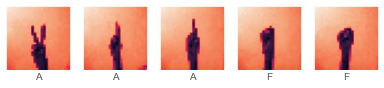

In [12]:
#train with stochastic gradient descent
epochs = 1001 #set the number of epochs for training all network
network_name ='3Layers_SGD'
net_3SGD = network(name=network_name,hidden_layer=3,shape=(256,128,64))
cf_net_3SGD = training_network(network=net_3SGD, optimizer='GD1',epochs=epochs)


## ADAM

Epoch : 0, Train loss : 2.5817 Train acc : 34.238, valid acc : 34.019, Run time : 0.4861
Epoch : 50, Train loss : 2.1760 Train acc : 92.756, valid acc : 92.497, Run time : 0.4318
Epoch : 100, Train loss : 2.1685 Train acc : 95.452, valid acc : 95.283, Run time : 0.4406
Epoch : 150, Train loss : 2.1701 Train acc : 95.133, valid acc : 94.846, Run time : 0.4425
Epoch : 200, Train loss : 2.1654 Train acc : 97.582, valid acc : 97.469, Run time : 0.4728
Epoch : 250, Train loss : 2.1655 Train acc : 98.152, valid acc : 98.252, Run time : 0.4351
Epoch : 300, Train loss : 2.1621 Train acc : 98.880, valid acc : 98.889, Run time : 0.4411
Epoch : 350, Train loss : 2.1684 Train acc : 97.300, valid acc : 97.250, Run time : 0.4281
Epoch : 400, Train loss : 2.1614 Train acc : 99.390, valid acc : 99.290, Run time : 0.4427
Epoch : 450, Train loss : 2.1614 Train acc : 99.376, valid acc : 99.272, Run time : 0.4577
Epoch : 500, Train loss : 2.1614 Train acc : 99.435, valid acc : 99.381, Run time : 0.4636
Ep

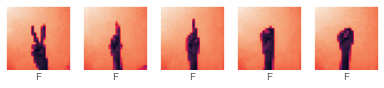

In [13]:
#train with ADAM gradient
network_name ='3Layer_ADAM'
tf.reset_default_graph()
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
net2 = network(name=network_name, hidden_layer=3,shape=(256,128,64))
result2 =training_network(network=net2, optimizer='ADAM',epochs=epochs)

## Momentum

Epoch : 0, Train loss : 2.4845 Train acc : 30.832, valid acc : 31.233, Run time : 0.4567
Epoch : 50, Train loss : 2.1672 Train acc : 94.313, valid acc : 94.172, Run time : 0.4233
Epoch : 100, Train loss : 2.1671 Train acc : 94.377, valid acc : 94.336, Run time : 0.4395
Epoch : 150, Train loss : 2.1670 Train acc : 94.559, valid acc : 94.427, Run time : 0.4231
Epoch : 200, Train loss : 2.1670 Train acc : 94.942, valid acc : 94.755, Run time : 0.4231
Epoch : 250, Train loss : 2.1669 Train acc : 95.042, valid acc : 94.846, Run time : 0.4354
Epoch : 300, Train loss : 2.1669 Train acc : 95.192, valid acc : 94.919, Run time : 0.4665
Epoch : 350, Train loss : 2.1669 Train acc : 95.215, valid acc : 94.901, Run time : 0.4246
Epoch : 400, Train loss : 2.1668 Train acc : 95.238, valid acc : 95.028, Run time : 0.4568
Epoch : 450, Train loss : 2.1668 Train acc : 95.297, valid acc : 95.137, Run time : 0.4389
Epoch : 500, Train loss : 2.1668 Train acc : 95.351, valid acc : 95.174, Run time : 0.4363
Ep

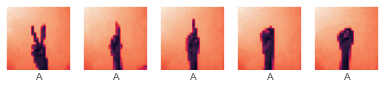

In [14]:
#train with momentum gradient
network_name ='3Layers_Momentum'
tf.reset_default_graph()
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
net_moment = network(name=network_name, hidden_layer=3,shape=(256,128,64))
result_moment = training_network(network=net_moment, optimizer='momentum',epochs=epochs)


## Dropout

با مقایسه با حالت عادی(اولین شبکه) در شبکه ای که drop out انجام میشود به وضوح دقت بهتر میشود و زودتر همگرا میشود اما چون شبکه کم عمق است نمیتوان کارایی آن را بهتر دید چراکه dropout علاوه بر افزودن randomness به شبکه برای گیر نکردن در local minima به عنوان regulaizer در جهت overfit نشدن و تعمیم مدل نیز استفاده میشود.

استدلال من این است که انگار یک نوع میانگین گیری (رای گیری) انجام میدهیم و خب چون اینکار باعث کاهش واریانس میشود (وقتی n تا متغیر تصادفی iid رو جمع میکنیم امید ریاضی ثابت میمونه اما واریانس با فاکتور 1/n کاهش پیدا میکنه البته خب اینجا قطعا از 1/n کمتره چون از هم کاملا مستقل نیستن ولی خب به هر حال واریانس کاهش پیدا میکنه)

Epoch : 0, Train loss : 2.8724 Train acc : 16.199, valid acc : 15.935, Run time : 0.5435
Epoch : 50, Train loss : 2.2435 Train acc : 72.632, valid acc : 72.045, Run time : 0.4898
Epoch : 100, Train loss : 2.1949 Train acc : 87.288, valid acc : 87.124, Run time : 0.4911
Epoch : 150, Train loss : 2.1796 Train acc : 91.950, valid acc : 91.623, Run time : 0.4873
Epoch : 200, Train loss : 2.1740 Train acc : 93.549, valid acc : 93.626, Run time : 0.4899
Epoch : 250, Train loss : 2.1709 Train acc : 94.450, valid acc : 94.336, Run time : 0.4735
Epoch : 300, Train loss : 2.1697 Train acc : 94.669, valid acc : 94.537, Run time : 0.4931
Epoch : 350, Train loss : 2.1691 Train acc : 94.791, valid acc : 94.628, Run time : 0.5068
Epoch : 400, Train loss : 2.1687 Train acc : 94.746, valid acc : 94.609, Run time : 0.4921
Epoch : 450, Train loss : 2.1685 Train acc : 94.814, valid acc : 94.646, Run time : 0.5257
Epoch : 500, Train loss : 2.1688 Train acc : 94.796, valid acc : 94.537, Run time : 0.5122
Ep

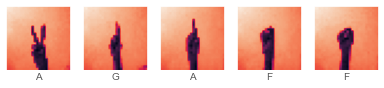

In [15]:
#train with dropout
network_name ='3Layers_Dropout'
tf.reset_default_graph()    
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
net_drop = network(name=network_name,hidden_layer=3,shape=(256,128,64),keep_prob=0.95)
result_drop = training_network(network=net_drop, optimizer='GD',epochs=epochs)



## batch_normalization

با افزایش تعداد لایه های شبکه قدرت مدل افزایش میابد همچنین اضافه کردن batch normalization است باعث میشود در تعداد epoch کمتر به دقت بهتری برسد با این حال این کار باعث میشود زمان اجرای هر epoch را بیشتر شود(با مقایسه زمان اجرا متوجه میشویم اولی حدود 500 ثانیه طول کشیده است اما دومی حدود 1000 ثانیه یعنی تقریبا دو برابر) اما همانطور که گفته شد سرعت همگرایی را بیشتر میکند بنابراین میتوان کاهش زمان همگرایی را به عنوان مزیت آن دانست.

همچنین اینکار باعث جلوگیری از تغییرات شدید میشود مثلا اگه یه نورن اتفاقی وزنش زیاد شود ممکن است باعث واگرایی شود. در واقع میتوان گفت به تعبیری اینکار باعث میشود هر نورون همان یادگیری که انتظارش را دارد برایش رقم بخورد.

همانطور که در توضیحات گفته شد هرچه از لایه ورودی فاصله میگریم (شبکه عمیق تر میشه) واریانس وزن ها بیشتر میشود و خب این باعث میشود وزن ها توزیع مناسبی نداشته باشند همچنین با افزوده شدن لایه گرادیان بیشتر نزدیک صفر میشه (چون هی یه سری عدد کمتر از یک در هم ضرب میشه) بنابراین نرمالیزیشن بکنیم میتونیم شبکه رو عمیق تر و به قدرت مدل را بیشتر کنیم

البته خب اینجا چون خیلی دیپ نشدیم (خواستم بشما ولی خب به اندازه کافی سر تمرین نابود شدم که نخوام همچین غلطی کنم) لذا خیلی تاثیریشو ندیدیم


Epoch : 0, Train loss : 3.0147 Train acc : 7.785, valid acc : 7.758, Run time : 0.5895
Epoch : 50, Train loss : 2.2485 Train acc : 64.660, valid acc : 63.996, Run time : 0.5358
Epoch : 100, Train loss : 2.3156 Train acc : 69.564, valid acc : 69.878, Run time : 0.5558
Epoch : 150, Train loss : 2.1692 Train acc : 93.740, valid acc : 93.553, Run time : 0.5452
Epoch : 200, Train loss : 2.1692 Train acc : 94.190, valid acc : 94.063, Run time : 0.5060
Epoch : 250, Train loss : 2.1692 Train acc : 94.423, valid acc : 94.354, Run time : 0.5597
Epoch : 300, Train loss : 2.1692 Train acc : 94.600, valid acc : 94.464, Run time : 0.5310
Epoch : 350, Train loss : 2.1692 Train acc : 94.464, valid acc : 94.391, Run time : 0.5634
Epoch : 400, Train loss : 2.1692 Train acc : 94.646, valid acc : 94.609, Run time : 0.5412
Epoch : 450, Train loss : 2.1692 Train acc : 94.746, valid acc : 94.828, Run time : 0.5360
Epoch : 500, Train loss : 2.1692 Train acc : 94.860, valid acc : 94.846, Run time : 0.5551
Epoc

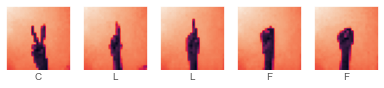

In [16]:
#increse layer but without batch normalization
tf.reset_default_graph()  
network_name = '8Layers_Ordinary'
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
net_layer8 = network(name=network_name,hidden_layer=8,shape=(512,256,128,64,64,128,256,512))
result8 = training_network(network=net_layer8, optimizer='GD',epochs=epochs)

Epoch : 0, Train loss : 3.0143 Train acc : 5.268, valid acc : 5.190, Run time : 0.9762
Epoch : 50, Train loss : 2.2729 Train acc : 55.063, valid acc : 54.070, Run time : 0.9444
Epoch : 100, Train loss : 2.1713 Train acc : 91.390, valid acc : 91.240, Run time : 0.9200
Epoch : 150, Train loss : 2.1708 Train acc : 91.969, valid acc : 92.133, Run time : 1.0880
Epoch : 200, Train loss : 2.1708 Train acc : 91.659, valid acc : 91.787, Run time : 1.0090
Epoch : 250, Train loss : 2.1682 Train acc : 92.365, valid acc : 92.643, Run time : 0.9148
Epoch : 300, Train loss : 2.1682 Train acc : 92.538, valid acc : 92.861, Run time : 1.1452
Epoch : 350, Train loss : 2.1682 Train acc : 92.597, valid acc : 92.989, Run time : 1.1994
Epoch : 400, Train loss : 2.1682 Train acc : 92.629, valid acc : 92.734, Run time : 0.9099
Epoch : 450, Train loss : 2.1682 Train acc : 93.234, valid acc : 93.207, Run time : 1.0364
Epoch : 500, Train loss : 2.1682 Train acc : 93.417, valid acc : 93.335, Run time : 1.0400
Epoc

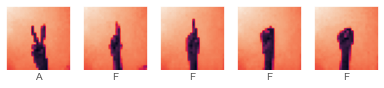

In [17]:
#increse layer and have batch normalization
tf.reset_default_graph()    
network_name = '8Layers_BatchNormalization'
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
net_layer8_batch = network(name=network_name,hidden_layer=8,shape=(512,256,128,64,64,128,256,512), batch_normalization=True)
result8_batch = training_network(network=net_layer8_batch, optimizer='GD',epochs=epochs)

## Unbalanced Data

همانطور که مشخص است با کاهش سایز کلاس 16 دقت این کلاس روی داده های آموزش افت میکند (از 88 درصد به حدود صفر درصد برسد) همچنین دقت روی کل داده ها نیز افت میکند به این دلیل دقت روی این کلاس انقدر افت کرده است چون مدل دقت روی کل داده ها در مجموع برایش مهم است لذا چون داده های این دسته کمتر بوده تاثیر کمتری در مجموع نداشته و مدل بیشتر به اکثریت توجه کرده


راه حل هایی که به نظرم میرسه

خب داده ها رو زیاد کنیم :) البته چون اینجا راحته وگرنه معمولا اینکار هزینه زیادی داره

بیاییم معیار loss مان را کمی تغییر دهیم مثلا به داده های این کلاس ضریب بیشتری در فرمول loss نسبت دهیم تا مدل برای یادگیریشان بیشتر تلاش کند.

با کمک Data Augmentation سعی کنیم توزیع داده ها را متعادل تر کنیم یعنی سعی کنیم با کمک داده های همین کلاس داده هایی شبیه آن ها تولید کنیم و داده هایمان بیافزایم مثلا یه عکسو کج کنیم به چپ یا راست قرینه کنیم یا بچرخونیمش


In [18]:
#print accuracy of all classes and plotting heatmap of confusion matrix a network
def acc_classes_plot_heatmap(conf_mat):
    plt.figure(figsize=(24,24))
    sns.heatmap(conf_mat, annot=True, cmap='BrBG') #plot heatmap of confusion_matrix
    acc_array = np.array([]) #accuracy score of all classes
    for index,row in enumerate(conf_mat):
#         print((index),row[0], np.sum(row))
#         print(row[0]/np.sum(row))
        acc_array=np.append(acc_array,row[index]/np.sum(row))
        print("accuracy class {0} : {1:.2f}".format(index, acc_array[index]))    

#decrese size of training data based on class 16
def decrese_size_class(X_train, y_train, class_id, decrese_size):
    itemindex = np.where(y_train[:,class_id]==1)[0]
    np.random.shuffle(itemindex)
    remove_size = itemindex.size//decrese_size
    remove_index = itemindex[:-remove_size]
    X_new = np.delete(X_train, remove_index, axis=0)
    y_new = np.delete(y_train, remove_index, axis=0)
    return(X_new, y_new) 

accuracy class 0 : 0.52
accuracy class 1 : 1.00
accuracy class 2 : 0.98
accuracy class 3 : 0.91
accuracy class 4 : 0.95
accuracy class 5 : 0.92
accuracy class 6 : 0.95
accuracy class 7 : 0.91
accuracy class 8 : 0.96
accuracy class 9 : nan
accuracy class 10 : 0.98
accuracy class 11 : 1.00
accuracy class 12 : 0.86
accuracy class 13 : 0.91
accuracy class 14 : 1.00
accuracy class 15 : 1.00
accuracy class 16 : 0.99
accuracy class 17 : 0.95
accuracy class 18 : 0.92
accuracy class 19 : 0.95
accuracy class 20 : 0.93
accuracy class 21 : 0.95
accuracy class 22 : 1.00
accuracy class 23 : 0.95


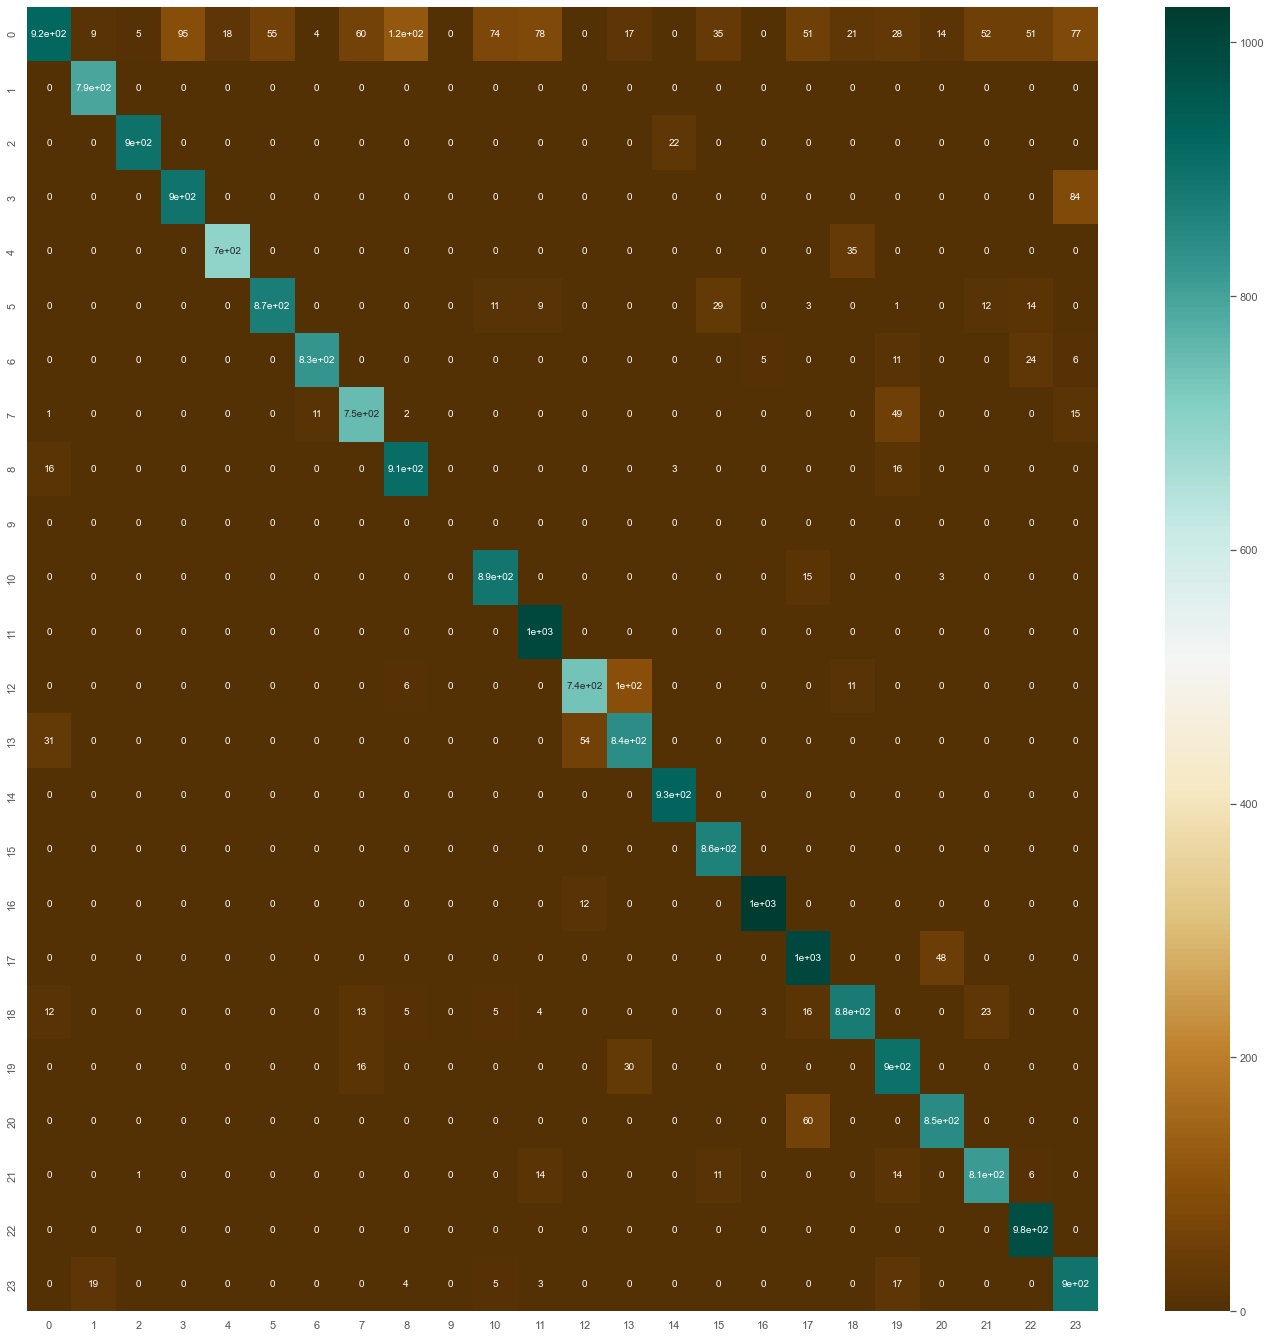

In [19]:
#show confusion_matrix 3Layers_SGD network
acc_classes_plot_heatmap(cf_net_3SGD)

In [20]:
print('shape X_train:', X_train.shape)
print('shape y_train:', y_train.shape)
X_train, y_train = decrese_size_class(X_train,y_train, class_id=16, decrese_size=5)
num_train = X_train.shape[0]
print('shape X_train new:', X_train.shape)
print('shape y_train new:', y_train.shape)

shape X_train: (21964, 784)
shape y_train: (21964, 24)
shape X_train new: (21132, 784)
shape y_train new: (21132, 24)


Epoch : 0, Train loss : 2.9118 Train acc : 15.905, valid acc : 15.680, Run time : 0.4271
Epoch : 50, Train loss : 2.2450 Train acc : 71.087, valid acc : 69.077, Run time : 0.3844
Epoch : 100, Train loss : 2.2744 Train acc : 70.358, valid acc : 67.802, Run time : 0.4091
Epoch : 150, Train loss : 2.1830 Train acc : 87.748, valid acc : 84.520, Run time : 0.3796
Epoch : 200, Train loss : 2.1807 Train acc : 88.600, valid acc : 85.412, Run time : 0.3911
Epoch : 250, Train loss : 2.1799 Train acc : 89.125, valid acc : 85.922, Run time : 0.3857
Epoch : 300, Train loss : 2.1797 Train acc : 89.258, valid acc : 86.123, Run time : 0.3869
Epoch : 350, Train loss : 2.1795 Train acc : 89.244, valid acc : 86.141, Run time : 0.3959
Epoch : 400, Train loss : 2.1793 Train acc : 89.272, valid acc : 86.105, Run time : 0.3962
Epoch : 450, Train loss : 2.1792 Train acc : 89.419, valid acc : 86.250, Run time : 0.3909
Epoch : 500, Train loss : 2.1791 Train acc : 89.409, valid acc : 86.305, Run time : 0.3795
Ep

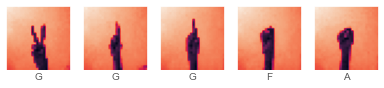

In [21]:
# train with network with decrese data from class 16
tf.reset_default_graph() 
network_name = '3Layers_with_Unbalnced_data'
input_X = tf.placeholder(dtype=tf.float32, shape=(None, num_features))
output_y = tf.placeholder(dtype=tf.float32, shape=(None, num_classes))
cf_net_with_unbalnced_data = network(name=network_name, hidden_layer=3,shape=(256,128,64))
result_conf = training_network(network=cf_net_with_unbalnced_data, optimizer='GD1',epochs=epochs)



accuracy class 0 : 0.51
accuracy class 1 : 0.98
accuracy class 2 : 1.00
accuracy class 3 : 0.92
accuracy class 4 : 0.97
accuracy class 5 : 0.92
accuracy class 6 : 0.95
accuracy class 7 : 0.86
accuracy class 8 : 0.96
accuracy class 9 : nan
accuracy class 10 : 0.91
accuracy class 11 : 1.00
accuracy class 12 : 0.87
accuracy class 13 : 0.97
accuracy class 14 : 0.95
accuracy class 15 : 1.00
accuracy class 16 : 0.00
accuracy class 17 : 0.97
accuracy class 18 : 0.84
accuracy class 19 : 0.98
accuracy class 20 : 0.83
accuracy class 21 : 1.00
accuracy class 22 : 0.98
accuracy class 23 : 0.95


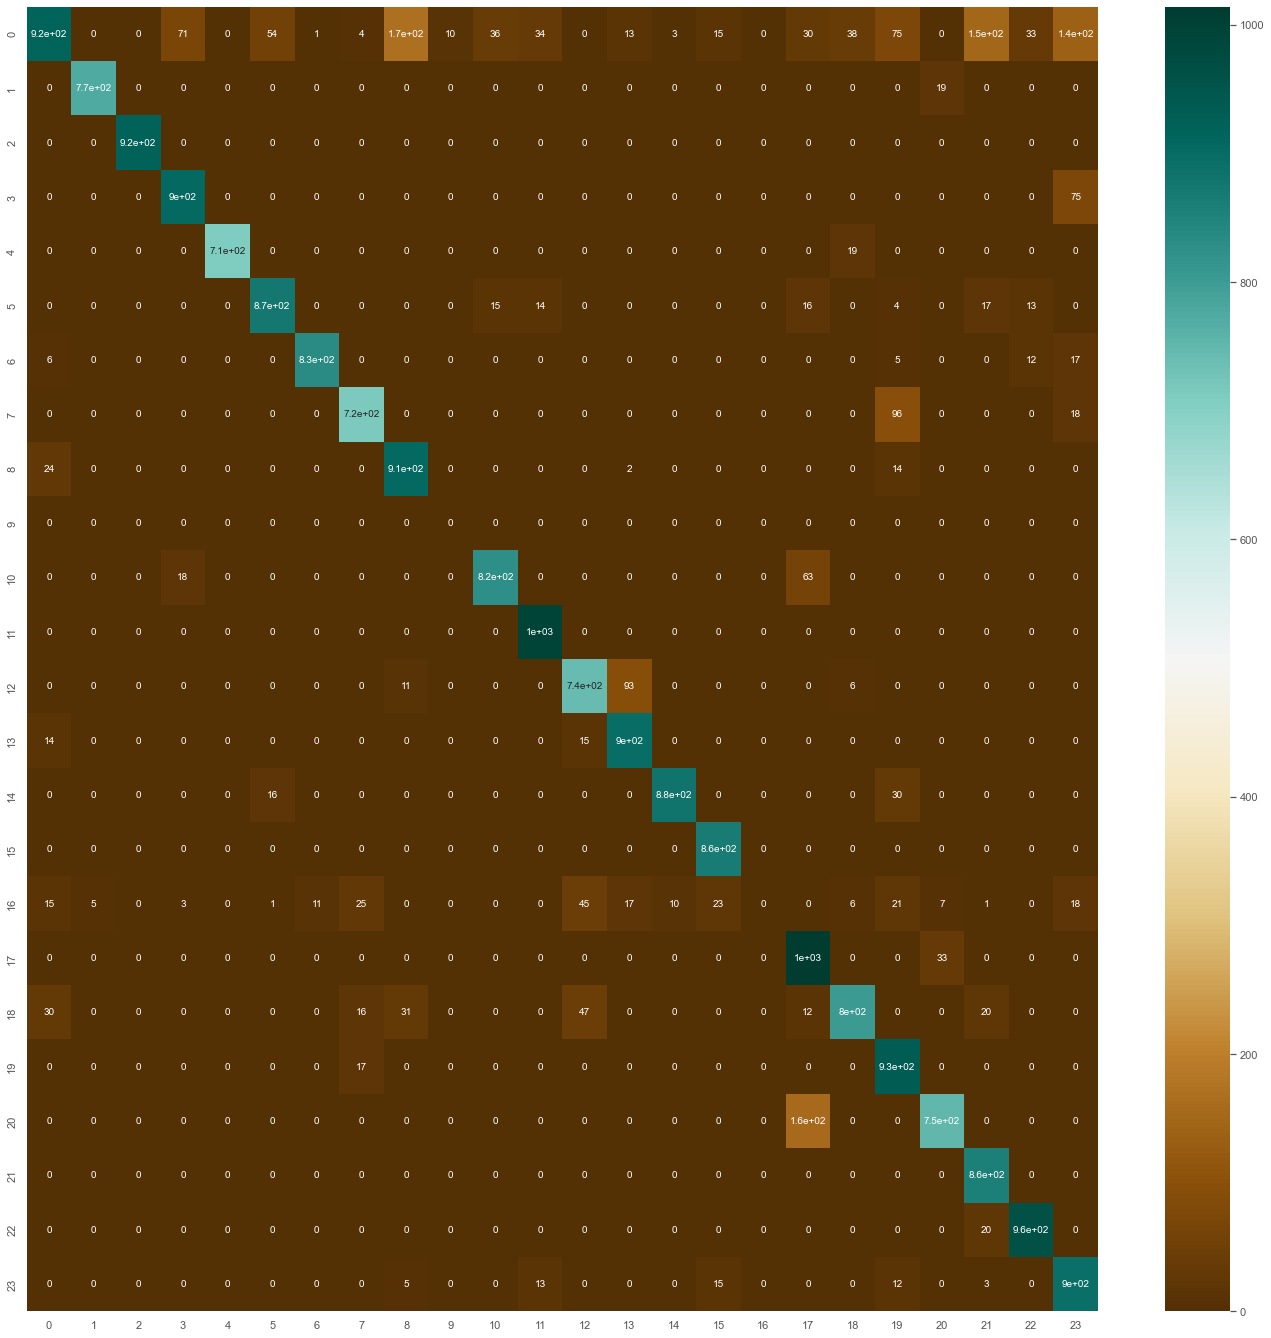

In [22]:
#show confusion_matrix 3Layers_SGD network with unbalnced data
acc_classes_plot_heatmap(result_conf)

In [23]:
#  conda activate tf1
# tensorboard --logdir=".\graphs" --port=6060

# my test

به وضوح تست روی هیچکدوم از شبکه ها اصلن خوب جواب نداده به نظرم میتونه به خاطر بایاس داده های تست من باشه که توزیعشون با توزیع داده های شما فرق داره همچنین داده های من چون به شکل بدی کاهش سایز داده شدن ممکنه به خاطر اینم باشه

خب دیگه من که نموده شدم بای بای